Reading the dataset of ignitions started with Electric line.

In [125]:
import numpy as np
import pandas as pd
import random
import itertools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from fitter import Fitter, get_common_distributions, get_distributions

In [126]:
df = pd.read_csv("Dataset.csv", encoding = 'latin1')

In [127]:
new_df = df.drop(['OBJECTID1','File_tag','Provider','Date','Address_of_incident_4','CODE','NAME','ID_of__nearest__asset_5',
             'ID_of_nearest__polyphase__line_','Type_of_primary_asset__involved','Kind_of_fire_start_as_per_Claus',
             'Location__area_12','Fire__danger__rating_13','DNSP_record_number_14','OSIRIS___ESV__reference__number',
             'Fault__description_16','Overhead_conductors','BUFF_DIST','FOR_CODE','STATION_ID','CODE','NAME','WeatherStation',
             'Voltage_of_line_in_which__fire_','Network_categorisation_8','Phase_s__of__line_or__transform','FOR_TYPE','FOR_CAT'], axis = 1)

In [128]:
real_data_df = new_df.dropna()


In [129]:
real_data_df.head(3)

,DateOnly,Date_1,Time_2,Latitude_3,Longitude_3,Location_multiplier,Danger_multiplier,Product_of_multipliers,COVER,HEIGHT,FOREST,Elevation,Monthly Avg Rainfall,Monthly Mean Max Temperature,Monthly Mean Solar Exposure
1,24/01/2020,43854.00000,0.667361,-38.754127,143.667405,0.2,0.5,0.1,6,6,0,7.690627,129.4,26.9,21.8
3,20/02/2018,43151.69375,43151.693750,-38.669141,145.615890,0.2,1.0,0.2,6,6,0,25.977764,1.2,27,20.8
4,23/02/2018,43154.91458,43154.914580,-38.703816,145.819190,4.6,0.5,2.3,6,6,0,9.772949,1.2,27,20.8


In [130]:

real_data_df.shape

(1625, 15)

In [131]:
    # create cases list
    g_factors = [0.2,1.0,4.6,19.8]
    t_factors = [0.1,0.2,0.5,1,2.0,3.5,5]
    cases = [g_factors,t_factors]
    cases_list = list(itertools.product(*cases))

    # data frame for cases real 

    df_cases_real = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
    df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_real)))
    df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'count', 0)

        # classify records according to case type Real 

    group_rows_real = pd.DataFrame(real_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))

        # adding grouped rows to Real cases data frame
    for index_cases, row_cases in df_cases_real.iterrows():
        for index_records, row_records in group_rows_real.iterrows():
            if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
                df_cases_real.loc[index_cases, 'count'] =   row_records['count'] 

In [103]:
sim = 7000

penalty = np.zeros(sim)
sum_iru_real_arr =  np.zeros(sim)
sum_iru_imag_arr = np.zeros(sim)

diff_sum_abs =np.zeros(sim)
diff_sum_noabs = np.zeros(sim)
c_values = np.zeros(shape=[sim, 28])

for p in range(sim):

    #Randomly select N records from the dataset
    random.seed(10)
    total_records = len(real_data_df.index)
    random.seed(10)
    imag_data_df = real_data_df.sample(n=total_records,replace=True)


    # data frame for cases imag 

    df_cases_imag = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
    df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_imag)))
    df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'count', 0)


    # classify records according to case type Imag
    group_rows_imag = pd.DataFrame(imag_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))



    #Calculate impact factor for Real Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N 

    df_cases_real["IRU_real"] = df_cases_real["g_factors"] * df_cases_real["t_factors"] * df_cases_real["count"] 

    # adding grouped rows to Imag cases data frame
    for index_cases, row_cases in df_cases_imag.iterrows():
        for index_records, row_records in group_rows_imag.iterrows():
            if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
                df_cases_imag.loc[index_cases, 'count'] =   row_records['count'] 


    #Calculate impact factor for Imag Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N

    df_cases_imag["IRU_imag"] = df_cases_imag["g_factors"] * df_cases_imag["t_factors"] * df_cases_imag["count"] 

    # Objective
    x_penalty = 25000

    n_real = df_cases_real["count"] 
    n_imag = df_cases_imag["count"] 

    c0 = np.random.randn(28) 


    def objective(c0):
        i = 0
        iru_real = 0
        iru_imag = 0
        for i in range(27):
        # calculate Iru_real
            prod_real = c0[i] * n_real[i]
            iru_real = iru_real + prod_real
            #calculate Iru_imag
            prod_imag = c0[i] * n_imag[i] 
            iru_imag = iru_imag + prod_imag
        return (iru_real - iru_imag)

    # Contraints 

    def constraint1(c0):
        return c0[1] - c0[0]     # c2 - c1 >= 0

    def constraint2(c0):
        return c0[2] - c0[1]     # c3 - c2 >= 0 

    def constraint3(c0):
        return c0[3] - c0[2]     # c4 - c3 >= 0 

    def constraint4(c0):
        return c0[4] - c0[3]     # c5 - c4 >= 0

    def constraint5(c0):
        return c0[5] - c0[4]     # c6 - c5 >= 0

    def constraint6(c0):
        return c0[6] - c0[5]     # c7 - c6 >= 0

    def constraint7(c0):
        return c0[7] - c0[6]     # c8 - c1 >= 0  cant be because of row.

    def constraint8(c0):
        return c0[8] - c0[7]     # c9 - c8 >= 0

    def constraint9(c0):
        return c0[9] - c0[8]     # c10 - c9 >= 0

    def constraint10(c0):
        return c0[10] - c0[9]    # c11 - c10 >= 0

    def constraint11(c0):
        return c0[11] - c0[10]   # c12 - c11 >= 0

    def constraint12(c0):
        return c0[12] - c0[11]   # c13 - c12 >= 0

    def constraint13(c0):
        return c0[13] - c0[12]   # c14 - c1 >= 0  cant be because of row 

    def constraint14(c0):
        return c0[14] - c0[13]   # c15 - c14 >= 0

    def constraint15(c0):
        return c0[15] - c0[14]   # c16 - c15 >= 0

    def constraint16(c0):
        return c0[16] - c0[15]   # c17 - c16 >= 0

    def constraint17(c0):
        return c0[17] - c0[16]   # c18 - c17 >= 0

    def constraint18(c0):
        return c0[18] - c0[17]   # c19 - c18 >= 0

    def constraint19(c0):
        return c0[19] - c0[18]   # c20 - c19 >= 0

    def constraint20(c0):
        return c0[20] - c0[19]   # c21 - c20 >= 0

    def constraint21(c0):
        return c0[21] - c0[20]   # c21 - c7 >= 0

    def constraint22(c0):
        return c0[22] - c0[21]   # c23 - c22 >= 0

    def constraint23(c0):
        return c0[23] - c0[22]   # c24 - c23 >= 0

    def constraint24(c0):
        return c0[24] - c0[23]   # c25 - c24 >= 0

    def constraint25(c0):
        return c0[25] - c0[24]   # c26 - c25 >= 0

    def constraint26(c0):
        return c0[26] - c0[25]   # c27 - c26 >= 0

    def constraint27(c0):
        return c0[27] - c0[26]   # c28 - c27 >= 0

    def constraint28(c0):
        i = 0
        iru_real = 0
        iru_imag = 0
        for i in range(27):
            # calculate Iru_real
            prod_real = c0[i] * n_real[i]
            iru_real = iru_real + prod_real
            #calculate Iru_imag
            prod_imag = c0[i] * n_imag[i] 
            iru_imag = iru_imag + prod_imag
        return ((iru_real - iru_imag) * 25000) - 1000000
   


    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    con5 = {'type': 'ineq', 'fun': constraint5}
    con6 = {'type': 'ineq', 'fun': constraint6}
    con7 = {'type': 'ineq', 'fun': constraint7}
    con8 = {'type': 'ineq', 'fun': constraint8}
    con9 = {'type': 'ineq', 'fun': constraint9}
    con10 = {'type': 'ineq', 'fun': constraint10}
    con11 = {'type': 'ineq', 'fun': constraint11}
    con12 = {'type': 'ineq', 'fun': constraint12}
    con13 = {'type': 'ineq', 'fun': constraint13}
    con14 = {'type': 'ineq', 'fun': constraint14}
    con15 = {'type': 'ineq', 'fun': constraint15}
    con16 = {'type': 'ineq', 'fun': constraint16}
    con17 = {'type': 'ineq', 'fun': constraint17}
    con18 = {'type': 'ineq', 'fun': constraint18}
    con19 = {'type': 'ineq', 'fun': constraint19}
    con20 = {'type': 'ineq', 'fun': constraint20}
    con21 = {'type': 'ineq', 'fun': constraint21}
    con22 = {'type': 'ineq', 'fun': constraint22}
    con23 = {'type': 'ineq', 'fun': constraint23}
    con24 = {'type': 'ineq', 'fun': constraint24}
    con25 = {'type': 'ineq', 'fun': constraint25}
    con26 = {'type': 'ineq', 'fun': constraint26}
    con27 = {'type': 'ineq', 'fun': constraint27}
    con28 = {'type': 'ineq', 'fun': constraint28}

    #optimize

    cons = ([con1,con2,con3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,con14,con15,con16,con17,con18,con19,con20,con21,con22,con23,con24,con25,con26,con27,con28])

    # optimize
    b = (1.0,100000.0)
    bnds = (b,b, b, b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b)
    solution = minimize(objective,c0,method='SLSQP',constraints=cons)
    x = solution.x
    # Save values of Cases for each c_real - c_imaginiary
    k = 0
    for k in range(len(x)):
        c_values[p][k] = x[k]
        k = k+1

    # dataframe with values of Cases

    df_cases_values = pd.DataFrame(x, columns=['values'])
    df_cases_values.insert((len(df_cases_values.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_values)))

    test_real_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
    test_real_df['count'] = df_cases_real['count']
    test_real_df['c'] = df_cases_values['values']
    test_real_df['IRU'] = test_real_df['count'] * test_real_df['c']
    sum_iru_real = np.sum(test_real_df['IRU'])


    test_imag_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
    test_imag_df['count'] = df_cases_imag['count']
    test_imag_df['c'] = df_cases_values['values']
    test_imag_df['IRU'] = test_imag_df['count'] * test_imag_df['c']
    sum_iru_imag = np.sum(test_imag_df['IRU'])

    # sum of iru imag
    sum_iru_imag_arr[p] = sum_iru_imag 
    # sum of iru real 
    sum_iru_real_arr[p] = sum_iru_real
    # sum diff bas
    diff_sum_abs[p] =  np.abs(sum_iru_real - sum_iru_imag)
    # sum diff no abs
    diff_sum_noabs[p] = sum_iru_real - sum_iru_imag
    # without scaling constant 
    penalty[p] = np.abs(sum_iru_real - sum_iru_imag) * 25000


In [132]:
import seaborn as sns
len(penalty)
max(penalty)

1000000.0118353909

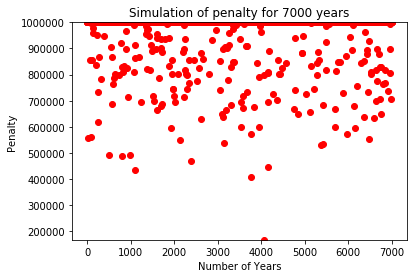

In [135]:

#figure(figsize=(8, 6), dpi=80)
plt.plot(penalty,"ro")
plt.ticklabel_format(style='plain')
#plt.boxplot(penalty)
plt.xlabel("Number of Years")
plt.ylabel("Penalty")
plt.title("Simulation of penalty for 7000 years")

#plt.set_ylim([min(penalty), max(penalty)])
plt.axis([None, None, min(penalty), max(penalty)])

plt.savefig('Simulationplot.jpg')



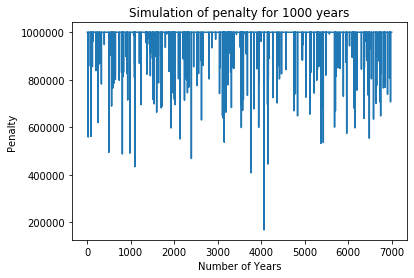

In [106]:

plt.plot(penalty)
plt.xlabel("Number of Years")
plt.ylabel("Penalty")
plt.title("Simulation of penalty for 1000 years")
plt.ticklabel_format(style='plain')
plt.show()

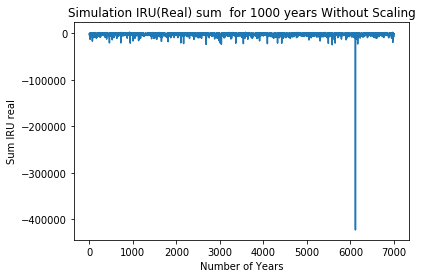

In [107]:
plt.plot(sum_iru_real_arr)
plt.xlabel("Number of Years")
plt.ylabel("Sum IRU real")
plt.title("Simulation IRU(Real) sum  for 1000 years Without Scaling")
plt.ticklabel_format(style='plain')
plt.show()

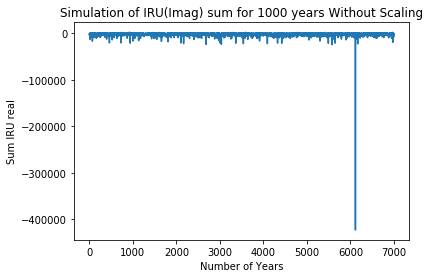

In [108]:

plt.plot(sum_iru_imag_arr)
plt.xlabel("Number of Years")
plt.ylabel("Sum IRU real")
plt.title("Simulation of IRU(Imag) sum for 1000 years Without Scaling")
plt.ticklabel_format(style='plain')
plt.show()

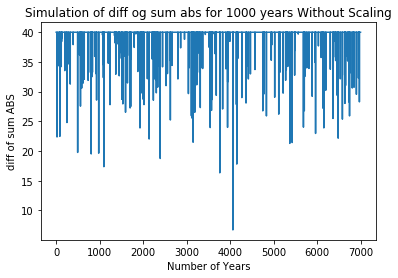

In [109]:
plt.plot(diff_sum_abs)
plt.xlabel("Number of Years")
plt.ylabel("diff of sum ABS")
plt.title("Simulation of diff og sum abs for 1000 years Without Scaling")
plt.ticklabel_format(style='plain')
plt.show()

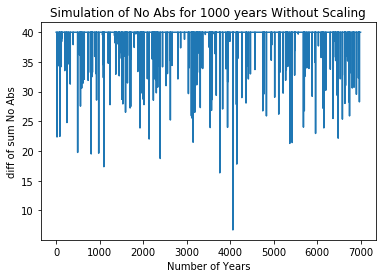

In [110]:
plt.plot(diff_sum_noabs)
plt.xlabel("Number of Years")
plt.ylabel("diff of sum No Abs")
plt.title("Simulation of No Abs for 1000 years Without Scaling")
plt.ticklabel_format(style='plain')
plt.show()

In [111]:
# Print ranges of  c values
max_values = c_values.max(axis=0, keepdims=True)
min_values = c_values.min(axis=0, keepdims=True)
t = 0 
print('Range of c values')
for t in range(len(max_values[0])):
    
    print('c'+ str(t) +' = ' + format(float(str(min_values[0][t])),'.2f') + '   to   ' + format(float(str(max_values[0][t])),'.2f'))
    t = t + 1

Range of c values
c0 = -259.72   to   2.44
c1 = -260.29   to   2.21
c2 = -260.29   to   3.06
c3 = -260.47   to   3.06
c4 = -260.48   to   3.06
c5 = -260.48   to   4.37
c6 = -260.49   to   4.37
c7 = -260.67   to   8.61
c8 = -260.67   to   11.58
c9 = -260.68   to   12.72
c10 = -260.69   to   13.77
c11 = -260.93   to   15.68
c12 = -260.93   to   15.68
c13 = -260.94   to   15.68
c14 = -261.01   to   19.40
c15 = -261.01   to   19.40
c16 = -261.01   to   22.60
c17 = -261.22   to   24.39
c18 = -261.22   to   25.98
c19 = -261.22   to   25.98
c20 = -261.22   to   28.58
c21 = -261.22   to   30.35
c22 = -261.24   to   31.73
c23 = -261.25   to   33.16
c24 = -261.31   to   34.54
c25 = -2.95   to   55.36
c26 = -2.69   to   55.39
c27 = -1.99   to   55.67


In [112]:

col = np.shape(c_values)[1]
col = col
c_values_for_all_sim = np.zeros((col,sim))

# Getting values of c1 to c28 fo all simulations

for i in range(col):
     c_values_for_all_sim[i]= c_values[:,i]

c_values_for_all_sim.shape



(28, 7000)

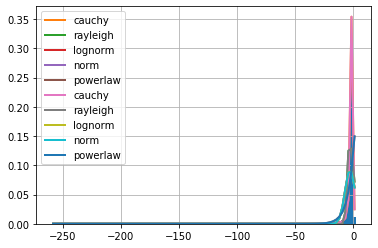

In [113]:
# Getting distribution for each c from c1 to c28
#C1
f = Fitter(c_values_for_all_sim[0],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()


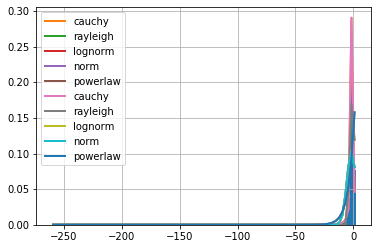

In [114]:
#C2
f = Fitter(c_values_for_all_sim[1],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()


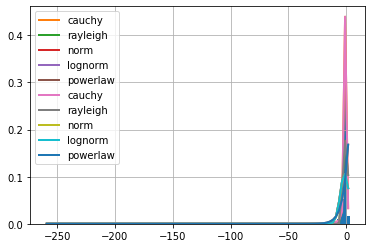

In [115]:
#C3
f = Fitter(c_values_for_all_sim[2],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

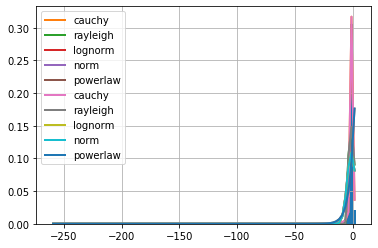

In [116]:
#C4
f = Fitter(c_values_for_all_sim[3],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

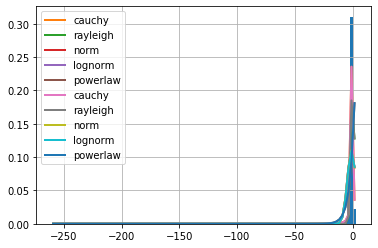

In [117]:
#C5
f = Fitter(c_values_for_all_sim[4],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

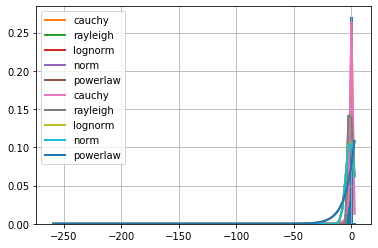

In [118]:
#C6
f = Fitter(c_values_for_all_sim[5],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

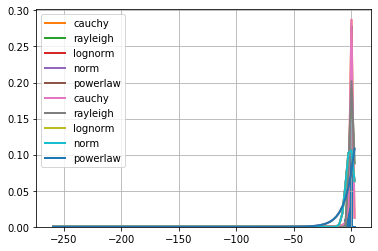

In [119]:
#C7
f = Fitter(c_values_for_all_sim[6],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

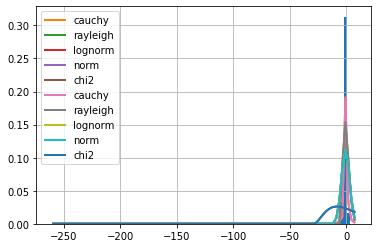

In [120]:
#C8
f = Fitter(c_values_for_all_sim[7],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

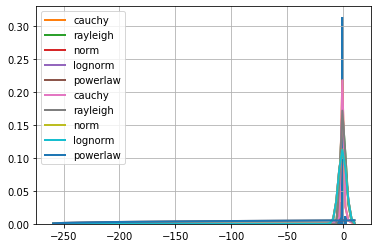

In [121]:
#C9
f = Fitter(c_values_for_all_sim[8],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()

{'cauchy': {'loc': 0.013025068864649419, 'scale': 0.3345195186625132}}

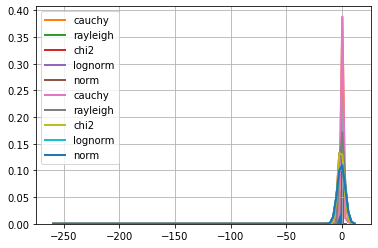

In [139]:
#C10
f = Fitter(c_values_for_all_sim[9],distributions= get_common_distributions())
f.fit()
f.summary()
f.plot_pdf()
f.get_best(method = 'sumsquare_error')

In [157]:

penalty = penalty.astype(int)
df_penalties = pd.DataFrame(penalty, columns=['penalty'])
df_penalties.insert((len(df_penalties.columns)-1)+1 , 'Number of Years', range(1, 1 + len(df_penalties)))
df_penalties['has1M'] = np.where(df_penalties['penalty'] == 1000000, 1, 0)

#df_penalties

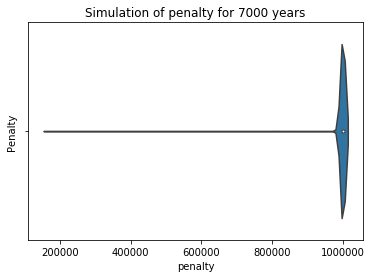

In [159]:


#plt.boxplot(df_penalties)
#plt.boxplot(penalty)
plt.xlabel("Number of Years")
plt.ylabel("Penalty")
plt.title("Simulation of penalty for 7000 years")

# create bar chart plot
#plt.hist(penalty)
# show plot


#plt.plot(penalty, linestyle = 'dotted')
sns.violinplot(x=df_penalties["penalty"])

sns.set(ylim=(0, None))
#sns.scatterplot(data=df_penalties, x="Number of Years", y="penalty", size="penalty", legend=False, sizes=(20, 60))


#plt.scatter('Number of Years', 'penalty', data=df_penalties)

#sns.set_theme(style="whitegrid", palette="muted")

# Load the penguins dataset

# Draw a categorical scatterplot to show each observation
#sns.swarmplot(data=df_penalties, x="Number of Years", y="has1M")



#plt.savefig('scatterbuble.jpg', dpi=100)
plt.show()
